In [1]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

# ARDC Training: Python Notebooks
Task-B: Water Extent (WOFS) and Water Quality (TSM)

> ### Import the Datacube Configuration

In [2]:
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app = 'ardc_task_b')
api.dc = dc

>### Browse the available Data Cubes   

In [3]:
list_of_products = dc.list_products()
netCDF_products = list_of_products[list_of_products['format'] == 'NetCDF']
netCDF_products

,name,description,format,lon,product_type,time,instrument,creation_time,label,lat,platform,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
13,ls7_ledaps_ghana,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LEDAPS,None,ETM,None,None,None,LANDSAT_7,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
17,ls7_ledaps_kenya,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LEDAPS,None,ETM,None,None,None,LANDSAT_7,EPSG:4326,"(-0.000269493, 0.000269493)","(0.99981903, 0.99981903)","(latitude, longitude)"
18,ls7_ledaps_senegal,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LEDAPS,None,ETM,None,None,None,LANDSAT_7,EPSG:4326,"(-0.000271152, 0.00027769)","(0.813456, 0.83307)","(latitude, longitude)"
16,ls7_ledaps_sierra_leone,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LEDAPS,None,ETM,None,None,None,LANDSAT_7,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
19,ls7_ledaps_tanzania,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LEDAPS,None,ETM,None,None,None,LANDSAT_7,EPSG:4326,"(-0.000271277688070265, 0.000271139577954979)","(0.999929558226998, 0.999962763497961)","(latitude, longitude)"
31,ls7_ledaps_vietnam,Landsat 7 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LEDAPS,None,ETM,None,None,None,LANDSAT_7,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
9,ls8_lasrc_ghana,Landsat 8 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LaSRC,None,OLI_TIRS,None,None,None,LANDSAT_8,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
10,ls8_lasrc_kenya,Landsat 8 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LaSRC,None,OLI_TIRS,None,None,None,LANDSAT_8,EPSG:4326,"(-0.000271309115317046, 0.00026957992707863)","(0.999502780827996, 0.999602369607559)","(latitude, longitude)"
11,ls8_lasrc_senegal,Landsat 8 USGS Collection 1 Higher Level SR sc...,NetCDF,None,LaSRC,None,OLI_TIRS,None,None,None,LANDSAT_8,EPSG:4326,"(-0.000271152, 0.00027769)","(0.813456, 0.83307)","(latitude, longitude)"


>### Pick a product  
>Use the platform and product names from the previous block to select a Data Cube.  

In [4]:
# Change the data platform and data cube here

platform = "LANDSAT_7"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_ghana"
# product = "ls7_ledaps_kenya"
# product = "ls7_ledaps_senegal"
# product = "ls7_ledaps_sierra_leone"
# product = "ls7_ledaps_tanzania"
product = "ls7_ledaps_vietnam"

> #### Display Latitude-Longitude and Time Bounds of the Data Cube

In [5]:
from utils.data_cube_utilities.dc_time import _n64_to_datetime, dt_to_str

extents = api.get_full_dataset_extent(platform = platform, product = product, measurements=[])

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print("Latitude Extents:", latitude_extents)
print("Longitude Extents:", longitude_extents)
print("Time Extents:", list(map(dt_to_str, map(_n64_to_datetime, time_extents))))

Latitude Extents: (9.176425374578418, 13.964805165051667)
Longitude Extents: (102.40430421277932, 108.93092407802477)
Time Extents: ['1999-09-08', '2016-12-29']


# Visualize Data Cube Region

In [6]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

> ### Pick a smaller analysis region and display that region
Try to keep your region to less than 0.2-deg x 0.2-deg for rapid processing. You can click on the map above to find the Lat-Lon coordinates of any location. You will want to identify a region with an inland water body. Pick a time window of a few months so we can pick out some clear pixels and plot the water. 

In [7]:
## Vietnam - Central Lam Dong Province ##
longitude_extents = (107.0, 107.2)
latitude_extents  = (11.7, 12.0)

time_extents = ('2010-01-01', '2010-12-31')

In [8]:
display_map(latitude = latitude_extents, longitude = longitude_extents)

## Load the dataset and the required spectral bands or other parameters
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [9]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [10]:
landsat_dataset
#view the dimensions and sample content from the cube

<xarray.Dataset>
Dimensions:      (latitude: 1114, longitude: 743, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-11T02:59:07 ... 2010-12-29T03:...
  * latitude     (latitude) float64 12.0 12.0 12.0 12.0 ... 11.7 11.7 11.7 11.7
  * longitude    (longitude) float64 107.0 107.0 107.0 ... 107.2 107.2 107.2
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 -9999 -9999 -9999 ... 546 586
    green        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 585 563
    blue         (time, latitude, longitude) int16 -9999 -9999 -9999 ... 487 465
    nir          (time, latitude, longitude) int16 -9999 -9999 ... 2905 2586
    swir1        (time, latitude, longitude) int16 -9999 -9999 ... 1710 1737
    swir2        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 817 903
    pixel_qa     (time, latitude, longitude) int32 1 1 1 1 1 ... 66 66 66 66 66
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

# Display Example Images  

>#### Single band visualization   
> For a quick inspection, let's look at one image. The code will allow the selection of any band (red, blue, green, nir, swir1, swir2) to produce a grey-scale image. Select the desired acquisition (time slice) in the block below. You can select from 1 to #, where the max value is the number of time slices noted in the block above. Change the comment statements below to select the bands for the first image.

In [11]:
acquisition_number = 2
# select an acquisition number from 1 to "time" using the array limits above

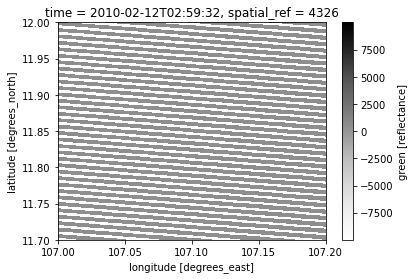

In [12]:
%matplotlib inline
#landsat_dataset.red.isel(time = acquisition_number).plot(cmap = "Greys")
landsat_dataset.green.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.blue.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.nir.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.swir1.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.swir2.isel(time = acquisition_number).plot(cmap = "Greys")

>#### Define Cloud Masking Function   
Removes clouds and cloud shadows based on the Landsat pixel QA information
This is only for reference ... nothing to modify here

In [13]:
import numpy as np  

def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def remove_clouds(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return dataset.where(a_clean_mask)

In [14]:
cloud_mask = generate_cloud_mask(landsat_dataset)
cloudless = remove_clouds(landsat_dataset) #landsat_dataset.where(image_is_clean)

>Set up plotting function (to be used later)
>Nothing to modify here

In [15]:
from utils.data_cube_utilities.dc_rgb import rgb

>** Most Recent Pixel Mosaic **   
>Masks clouds from imagery and uses the most recent cloud-free pixels.  

In [16]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic

def mrf_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [17]:
recent_composite = mrf_mosaic(landsat_dataset)

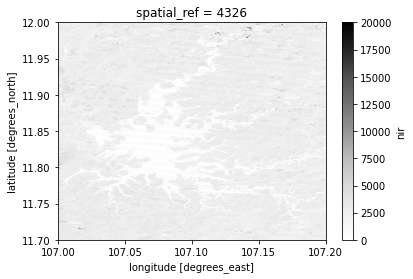

In [18]:
recent_composite.nir.plot(cmap = "Greys")

(<Figure size 1440x960.431 with 1 Axes>,
 <AxesSubplot:xlabel='longitude', ylabel='latitude'>)

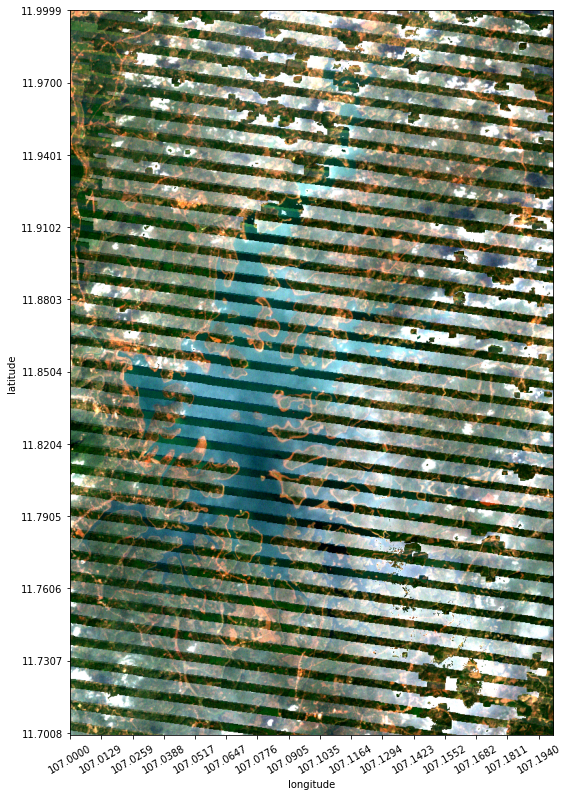

In [19]:
rgb(recent_composite, width = 20)

## Plot WOFS water detection results
This example uses the Australian Water Detection from Space (WOFS) algorithm for water detection. The base image will use a most-recent pixel composite (from above). When reviewing the results, 1=water, 0=no water. 

In [20]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

In [21]:
water_classification = wofs_classify(recent_composite, clean_mask = np.ones(recent_composite.pixel_qa.shape).astype(np.bool),  mosaic = True) 

/notebooks/utils/data_cube_utilities/dc_water_classifier.py:124: RuntimeWarning: invalid value encountered in true_divide
  return (a - b) / (a + b)


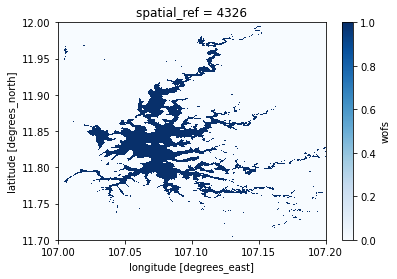

In [22]:
water_classification.wofs.plot(cmap='Blues')

## Plot NDWI water detection results
This example uses the Normalized Difference Water Index (NDWI) which is a spectral "index" that correlates well with the existance of water. 
<br>
$$ NDWI =  \frac{GREEN - NIR}{GREEN + NIR}$$  

In [23]:
def NDWI(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

In [24]:
ndwi = NDWI(recent_composite)  # High Concentrations of Water - Blues  

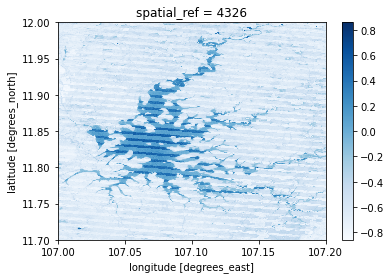

In [25]:
(ndwi).plot(cmap = "Blues")

## Plot TSM water quality results
This example uses the Australian Total Suspended Matter (TSM) algorithm. The TSM value is the mean over the entire time range. This parameter is a measure of the particulate matter in water and is often a proxy for water quality.

In [26]:
from utils.data_cube_utilities.dc_water_quality import tsm

In [27]:
mask_that_only_includes_water_pixels = water_classification.wofs == 1  
tsm_dataset = tsm(recent_composite, clean_mask = mask_that_only_includes_water_pixels )

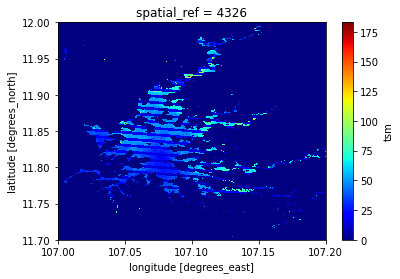

In [28]:
tsm_dataset.tsm.plot(cmap = "jet")

## Time Series Water Detection Analysis
Time series output of the Australian Water Detection from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [29]:
ts_water_classification = wofs_classify(landsat_dataset,clean_mask = np.invert(cloud_mask)) 

In [30]:
# Apply nan to no_data values
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999)

##Time series aggregation that ignores nan values.    
water_classification_percentages = (ts_water_classification.mean(dim = ['time']) * 100).wofs.rename('water_classification_percentages')

/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet_r"))
  This is separate from the ipykernel package so we can avoid doing imports until


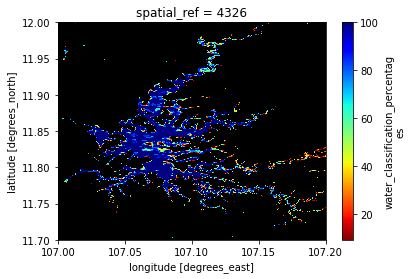

In [31]:
## import color-scheme and set nans to black
from matplotlib.cm import jet_r as jet_r
jet_r.set_bad('black',1)

## apply nan to percentage values that aren't greater than 0, then plot
water_classification_percentages\
    .where(water_classification_percentages > 0)\
    .plot(cmap = jet_r)

## Create a WOFS plot for a single pixel
First select the Lat-Lon position. Then the code will find the closest pixel in the dataset using a "nearest neighbor" selection.

In [32]:
pixel_lat = 11.84
pixel_lon = 107.09

In [33]:
pixel = ts_water_classification.sel( latitude  = pixel_lat,
                                     longitude = pixel_lon,
                                     method = 'nearest') # nearest neighbor selection  

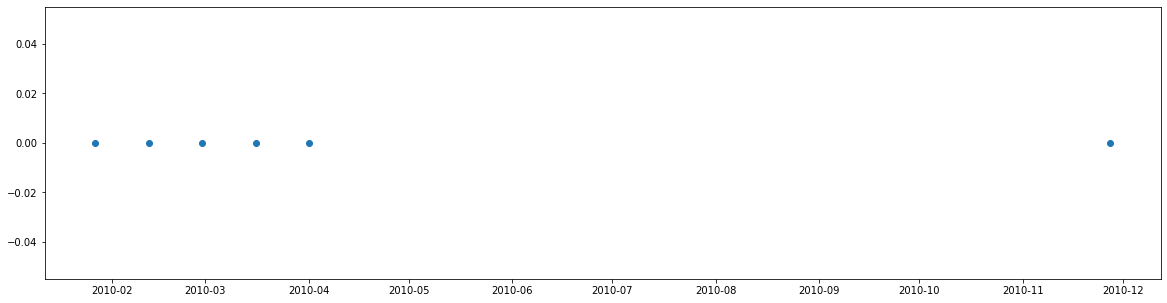

In [34]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (20,5)) 
plt.scatter(pixel.time.values, pixel.wofs.values)